In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Union
import math
from tqdm import tqdm
import os

# Diffusers components
from diffusers import UNet2DConditionModel, DDPMScheduler, AutoencoderKL
from diffusers.models.attention_processor import AttnProcessor2_0
from transformers import CLIPTextModel, CLIPTokenizer

# Accelerate for multi-GPU training
from accelerate import Accelerator

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check for multiple GPUs
if torch.cuda.is_available():
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("CUDA not available. Using CPU.")

c:\Users\Shlomi\Desktop\Projects\final_project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 3070


In [2]:
class TextConditionedCIFAR10(Dataset):
    """
    CIFAR-10 dataset with text conditioning.
    Each image is paired with a simple text description based on its class.
    """
    
    # CIFAR-10 class names and simple descriptions
    CLASS_NAMES = [
        "airplane", "automobile", "bird", "cat", "deer", 
        "dog", "frog", "horse", "ship", "truck"
    ]
    
    # Simple text templates for each class
    TEXT_TEMPLATES = {
        "airplane": ["a flying airplane", "an aircraft in the sky", "a plane flying"],
        "automobile": ["a red car", "a blue car", "a vehicle on road", "an automobile"],
        "bird": ["a colorful bird", "a flying bird", "a small bird"],
        "cat": ["a cute cat", "a sitting cat", "a furry cat"],
        "deer": ["a brown deer", "a wild deer", "a deer in nature"],
        "dog": ["a friendly dog", "a cute dog", "a pet dog"],
        "frog": ["a green frog", "a small frog", "a jumping frog"],
        "horse": ["a brown horse", "a running horse", "a beautiful horse"],
        "ship": ["a sailing ship", "a boat on water", "a naval vessel"],
        "truck": ["a large truck", "a delivery truck", "a heavy vehicle"]
    }
    
    def __init__(self, root_dir="../../../datasets", train=True, transform=None):
        # Load CIFAR-10 dataset
        self.cifar10 = CIFAR10(
            root=root_dir, 
            train=train, 
            download=True, 
            transform=None  # We'll apply transforms manually
        )
        
        # Default transform if none provided
        if transform is None:
            self.transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
            ])
        else:
            self.transform = transform
            
        # Text tokenizer
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        
    def __len__(self):
        return len(self.cifar10)
    
    def __getitem__(self, idx):
        # Get image and label from CIFAR-10
        image, label = self.cifar10[idx]
        
        # Apply image transforms
        if self.transform:
            image = self.transform(image)
            
        # Get class name and random text description
        class_name = self.CLASS_NAMES[label]
        text_options = self.TEXT_TEMPLATES[class_name]
        text = np.random.choice(text_options)
        
        # Tokenize text
        text_inputs = self.tokenizer(
            text,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        
        return {
            "image": image,
            "text": text,
            "text_input_ids": text_inputs.input_ids.squeeze(0),
            "text_attention_mask": text_inputs.attention_mask.squeeze(0),
            "label": label
        }

# Test the dataset
print("Creating dataset...")
dataset = TextConditionedCIFAR10(train=True)
print(f"Dataset size: {len(dataset)}")

# Show a sample
sample = dataset[0]
print(f"Sample text: '{sample['text']}'")
print(f"Image shape: {sample['image'].shape}")
print(f"Text input IDs shape: {sample['text_input_ids'].shape}")
print(f"Label: {sample['label']} ({dataset.CLASS_NAMES[sample['label']]})")

Creating dataset...
Dataset size: 50000
Sample text: 'a jumping frog'
Image shape: torch.Size([3, 32, 32])
Text input IDs shape: torch.Size([77])
Label: 6 (frog)
Dataset size: 50000
Sample text: 'a jumping frog'
Image shape: torch.Size([3, 32, 32])
Text input IDs shape: torch.Size([77])
Label: 6 (frog)


In [3]:
class SimpleTextConditionedUNet(nn.Module):
    """
    A simple UNet model for text-conditioned diffusion using diffusers blocks.
    Built from scratch using individual diffusers components.
    """
    
    def __init__(
        self,
        sample_size: int = 32,
        in_channels: int = 3,
        out_channels: int = 3,
        layers_per_block: int = 2,
        block_out_channels: Tuple[int] = (128, 256, 512, 512),
        down_block_types: Tuple[str] = (
            "CrossAttnDownBlock2D",
            "CrossAttnDownBlock2D", 
            "CrossAttnDownBlock2D",
            "DownBlock2D",
        ),
        up_block_types: Tuple[str] = (
            "UpBlock2D",
            "CrossAttnUpBlock2D",
            "CrossAttnUpBlock2D",
            "CrossAttnUpBlock2D",
        ),
        cross_attention_dim: int = 512,
    ):
        super().__init__()
        
        # Use diffusers UNet2DConditionModel as the base
        self.unet = UNet2DConditionModel(
            sample_size=sample_size,
            in_channels=in_channels,
            out_channels=out_channels,
            layers_per_block=layers_per_block,
            block_out_channels=block_out_channels,
            down_block_types=down_block_types,
            up_block_types=up_block_types,
            cross_attention_dim=cross_attention_dim,
            attention_head_dim=8,
        )
        
        # Text encoder (CLIP)
        self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze text encoder to save memory and training time
        for param in self.text_encoder.parameters():
            param.requires_grad = False
            
    def forward(self, sample, timestep, encoder_hidden_states, return_dict=True):
        """Forward pass through the UNet."""
        return self.unet(
            sample=sample,
            timestep=timestep,
            encoder_hidden_states=encoder_hidden_states,
            return_dict=return_dict
        )
    
    def encode_text(self, input_ids, attention_mask):
        """Encode text using CLIP text encoder."""
        text_outputs = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        return text_outputs.last_hidden_state

# Create the model
print("Creating UNet model...")
model = SimpleTextConditionedUNet(
    sample_size=32,
    cross_attention_dim=512,
)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Text encoder frozen parameters: {total_params - trainable_params:,}")

# Test forward pass
print("\nTesting forward pass...")
with torch.no_grad():
    # Create dummy inputs
    batch_size = 2
    dummy_sample = torch.randn(batch_size, 3, 32, 32)
    dummy_timestep = torch.randint(0, 1000, (batch_size,))
    dummy_input_ids = torch.randint(0, 1000, (batch_size, 77))
    dummy_attention_mask = torch.ones(batch_size, 77)
    
    # Encode text
    encoder_hidden_states = model.encode_text(dummy_input_ids, dummy_attention_mask)
    print(f"Encoder hidden states shape: {encoder_hidden_states.shape}")
    
    # Forward pass
    output = model(dummy_sample, dummy_timestep, encoder_hidden_states)
    print(f"Output shape: {output.sample.shape}")
    
print("✓ Model creation and forward pass successful!")

Creating UNet model...
Total parameters: 202,843,779
Trainable parameters: 139,677,827
Text encoder frozen parameters: 63,165,952

Testing forward pass...
Encoder hidden states shape: torch.Size([2, 77, 512])
Total parameters: 202,843,779
Trainable parameters: 139,677,827
Text encoder frozen parameters: 63,165,952

Testing forward pass...
Encoder hidden states shape: torch.Size([2, 77, 512])
Output shape: torch.Size([2, 3, 32, 32])
✓ Model creation and forward pass successful!
Output shape: torch.Size([2, 3, 32, 32])
✓ Model creation and forward pass successful!


In [4]:
# Training configuration
class TrainingConfig:
    def __init__(self):
        self.batch_size = 8  # Increased from 1 for better GPU utilization
        self.num_epochs = 5   # Reduced for faster demo
        self.learning_rate = 2e-4  # Slightly higher
        self.num_train_timesteps = 1000
        self.save_every_epochs = 5
        self.sample_every_epochs = 2
        self.mixed_precision = "fp16"  # Use mixed precision for faster training
        self.gradient_accumulation_steps = 1
        self.max_grad_norm = 1.0
        self.output_dir = "./outputs"

config = TrainingConfig()

# Create output directory
os.makedirs(config.output_dir, exist_ok=True)

# Initialize accelerator for multi-GPU training
accelerator = Accelerator(
    mixed_precision=config.mixed_precision,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
)

print(f"Training on {accelerator.num_processes} GPU(s)")
print(f"Mixed precision: {config.mixed_precision}")

# Noise scheduler (DDPM)
noise_scheduler = DDPMScheduler(
    num_train_timesteps=config.num_train_timesteps,
    beta_schedule="linear",
    prediction_type="epsilon"  # Predict noise
)

print(f"Noise scheduler: {noise_scheduler.__class__.__name__}")
print(f"Number of training timesteps: {config.num_train_timesteps}")

# Create data loader
print("Creating data loader...")
train_dataset = TextConditionedCIFAR10(train=True)

# Use a smaller subset for faster training and testing
subset_indices = torch.randperm(len(train_dataset))[:1000]  # Only 1000 samples
subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)

train_dataloader = DataLoader(
    subset_dataset, 
    batch_size=config.batch_size, 
    shuffle=True,
    num_workers=0,  # Set to 0 to avoid multiprocessing overhead
    pin_memory=False  # Disable for faster initialization
)

print(f"Batch size: {config.batch_size}")
print(f"Number of batches: {len(train_dataloader)}")
print(f"Dataset size: {len(subset_dataset)} (subset of {len(train_dataset)})")

# Test a batch
print("Testing batch loading...")
sample_batch = next(iter(train_dataloader))
print(f"✓ Sample batch - Images: {sample_batch['image'].shape}")
print(f"✓ Sample batch - Text input IDs: {sample_batch['text_input_ids'].shape}")
print(f"Sample texts: {sample_batch['text'][:3]}")  # Show first 3 texts

Training on 1 GPU(s)
Mixed precision: fp16
Noise scheduler: DDPMScheduler
Number of training timesteps: 1000
Creating data loader...
Batch size: 8
Number of batches: 125
Dataset size: 1000 (subset of 50000)
Testing batch loading...
✓ Sample batch - Images: torch.Size([8, 3, 32, 32])
✓ Sample batch - Text input IDs: torch.Size([8, 77])
Sample texts: [np.str_('a cute cat'), np.str_('a cute dog'), np.str_('a flying airplane')]
Batch size: 8
Number of batches: 125
Dataset size: 1000 (subset of 50000)
Testing batch loading...
✓ Sample batch - Images: torch.Size([8, 3, 32, 32])
✓ Sample batch - Text input IDs: torch.Size([8, 77])
Sample texts: [np.str_('a cute cat'), np.str_('a cute dog'), np.str_('a flying airplane')]


🔍 Showing dataset examples with text prompts...


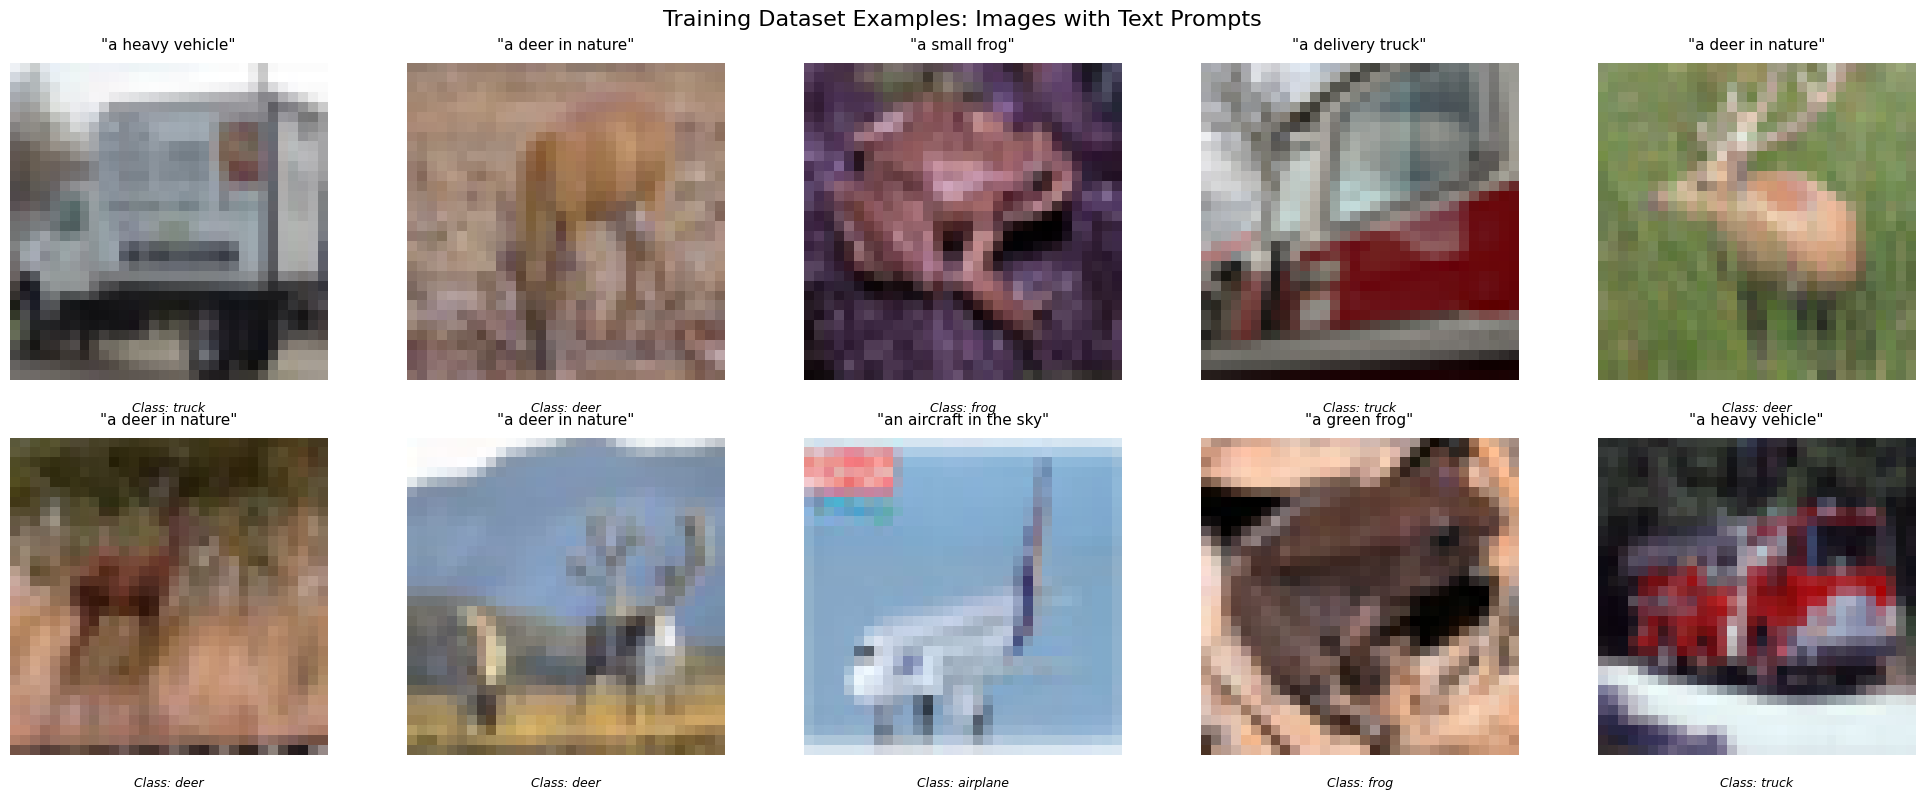


📊 Text Prompt Statistics:
Total dataset size: 50000 samples
Training subset size: 1000 samples
Batch size: 8
Number of batches per epoch: 125

📝 All possible text templates by class:
  airplane: ['a flying airplane', 'an aircraft in the sky', 'a plane flying']
  automobile: ['a red car', 'a blue car', 'a vehicle on road', 'an automobile']
  bird: ['a colorful bird', 'a flying bird', 'a small bird']
  cat: ['a cute cat', 'a sitting cat', 'a furry cat']
  deer: ['a brown deer', 'a wild deer', 'a deer in nature']
  dog: ['a friendly dog', 'a cute dog', 'a pet dog']
  frog: ['a green frog', 'a small frog', 'a jumping frog']
  horse: ['a brown horse', 'a running horse', 'a beautiful horse']
  ship: ['a sailing ship', 'a boat on water', 'a naval vessel']
  truck: ['a large truck', 'a delivery truck', 'a heavy vehicle']

🔤 Text encoding example:
Original text: 'a red car'
Tokenized length: 77 tokens
First 10 token IDs: [49406, 320, 736, 1615, 49407, 49407, 49407, 49407, 49407, 49407]

✅ Data

In [6]:
# 📸 DATASET EXAMPLES WITH TEXT PROMPTS
print("🔍 Showing dataset examples with text prompts...")

# Get some random samples from the training dataset
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Training Dataset Examples: Images with Text Prompts', fontsize=16, y=0.98)

# Show 10 random examples
random_indices = torch.randperm(len(subset_dataset))[:10]

for i, idx in enumerate(random_indices):
    row = i // 5
    col = i % 5
    
    # Get sample
    sample = subset_dataset[idx]
    
    # Denormalize image from [-1, 1] to [0, 1]
    image = (sample['image'] / 2 + 0.5).clamp(0, 1)
    image_np = image.numpy().transpose(1, 2, 0)
    
    # Display image
    axes[row, col].imshow(image_np)
    axes[row, col].set_title(f'"{sample["text"]}"', fontsize=11, pad=10)
    axes[row, col].axis('off')
    
    # Add class label as subtitle
    class_name = train_dataset.CLASS_NAMES[sample['label']]
    axes[row, col].text(0.5, -0.1, f'Class: {class_name}', 
                       transform=axes[row, col].transAxes, 
                       ha='center', fontsize=9, style='italic')

plt.tight_layout()
plt.show()

# Show text prompt statistics
print("\n📊 Text Prompt Statistics:")
print(f"Total dataset size: {len(train_dataset)} samples")
print(f"Training subset size: {len(subset_dataset)} samples")
print(f"Batch size: {config.batch_size}")
print(f"Number of batches per epoch: {len(train_dataloader)}")

# Show all possible text templates
print("\n📝 All possible text templates by class:")
for class_name, templates in train_dataset.TEXT_TEMPLATES.items():
    print(f"  {class_name}: {templates}")

# Show text encoding info
sample_text = "a red car"
tokenizer = train_dataset.tokenizer
text_inputs = tokenizer(sample_text, padding="max_length", max_length=77, return_tensors="pt")

print(f"\n🔤 Text encoding example:")
print(f"Original text: '{sample_text}'")
print(f"Tokenized length: {text_inputs.input_ids.shape[1]} tokens")
print(f"First 10 token IDs: {text_inputs.input_ids[0][:10].tolist()}")

print("\n✅ Dataset examples displayed! Ready for training.")

In [7]:
# 🎨 VISUALIZE TRAINING EXAMPLES WITH TEXT PROMPTS
print("📊 Creating comprehensive training data visualization...")

def show_training_examples(dataset, num_examples=16, figsize=(20, 12)):
    """Display training examples with their text prompts in a grid"""
    
    # Calculate grid dimensions
    cols = 4
    rows = num_examples // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle('Training Dataset: Images with Text Prompts', fontsize=18, y=0.98)
    
    # Get random samples
    random_indices = torch.randperm(len(dataset))[:num_examples]
    
    for i, idx in enumerate(random_indices):
        row = i // cols
        col = i % cols
        
        # Get sample
        sample = dataset[idx]
        
        # Denormalize image from [-1, 1] to [0, 1]
        image = (sample['image'] / 2 + 0.5).clamp(0, 1)
        image_np = image.numpy().transpose(1, 2, 0)
        
        # Display image
        axes[row, col].imshow(image_np)
        
        # Format title with text prompt
        text_prompt = sample["text"]
        class_name = train_dataset.CLASS_NAMES[sample['label']]
        
        # Wrap long text
        if len(text_prompt) > 20:
            text_prompt = text_prompt[:17] + "..."
            
        axes[row, col].set_title(f'"{text_prompt}"\n({class_name})', 
                                fontsize=11, pad=15, ha='center')
        axes[row, col].axis('off')
        
        # Add border color based on class
        colors = ['red', 'blue', 'green', 'orange', 'purple', 
                 'brown', 'pink', 'gray', 'olive', 'cyan']
        border_color = colors[sample['label'] % len(colors)]
        
        # Add colored border
        for spine in axes[row, col].spines.values():
            spine.set_edgecolor(border_color)
            spine.set_linewidth(3)
            spine.set_visible(True)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    return fig

def show_class_distribution(dataset):
    """Show distribution of classes and their text templates"""
    
    # Count samples per class
    class_counts = {}
    sample_texts = {class_name: [] for class_name in train_dataset.CLASS_NAMES}
    
    # Sample some examples to get text distribution
    sample_size = min(1000, len(dataset))
    sample_indices = torch.randperm(len(dataset))[:sample_size]
    
    for idx in sample_indices:
        sample = dataset[idx]
        class_name = train_dataset.CLASS_NAMES[sample['label']]
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
        sample_texts[class_name].append(sample['text'])
    
    # Plot class distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    
    # Bar chart of class counts
    classes = list(class_counts.keys())
    counts = list(class_counts.values())
    
    bars = ax1.bar(classes, counts, color='skyblue', alpha=0.7, edgecolor='navy')
    ax1.set_title(f'Class Distribution (Sample of {sample_size})', fontsize=14)
    ax1.set_xlabel('CIFAR-10 Classes')
    ax1.set_ylabel('Number of Samples')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add count labels on bars
    for bar, count in zip(bars, counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                str(count), ha='center', va='bottom')
    
    # Text templates per class
    y_pos = 0
    colors = plt.cm.Set3(np.linspace(0, 1, len(classes)))
    
    ax2.set_title('Text Templates by Class', fontsize=14)
    ax2.set_xlim(0, 10)
    ax2.set_ylim(-1, len(classes))
    
    for i, class_name in enumerate(classes):
        templates = train_dataset.TEXT_TEMPLATES[class_name]
        template_text = f"{class_name}:\n" + "\n".join([f"  • {t}" for t in templates])
        
        ax2.text(0.1, len(classes) - i - 1, template_text, 
                fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle="round,pad=0.3", facecolor=colors[i], alpha=0.3))
    
    ax2.set_xlim(0, 10)
    ax2.axis('off')
    
    plt.tight_layout()
    return fig

def show_text_encoding_stats(dataset):
    """Show statistics about text encoding"""
    
    print("🔤 TEXT ENCODING STATISTICS:")
    print("=" * 50)
    
    # Sample some texts to analyze
    sample_texts = []
    for i in range(min(100, len(dataset))):
        sample = dataset[i]
        sample_texts.append(sample['text'])
    
    # Text length statistics
    text_lengths = [len(text.split()) for text in sample_texts]
    
    print(f"Total unique texts sampled: {len(set(sample_texts))}")
    print(f"Average text length: {np.mean(text_lengths):.1f} words")
    print(f"Min text length: {min(text_lengths)} words")
    print(f"Max text length: {max(text_lengths)} words")
    
    # Show tokenization example
    tokenizer = train_dataset.tokenizer
    example_text = sample_texts[0]
    
    text_inputs = tokenizer(
        example_text,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt"
    )
    
    print(f"\nTokenization Example:")
    print(f"Original text: '{example_text}'")
    print(f"Max sequence length: {tokenizer.model_max_length}")
    print(f"Tokenized shape: {text_inputs.input_ids.shape}")
    print(f"First 15 tokens: {text_inputs.input_ids[0][:15].tolist()}")
    
    # Decode first few tokens to show what they represent
    decoded_tokens = [tokenizer.decode([token_id]) for token_id in text_inputs.input_ids[0][:10]]
    print(f"Decoded tokens: {decoded_tokens}")
    
    return {
        'text_lengths': text_lengths,
        'unique_texts': len(set(sample_texts)),
        'sample_texts': sample_texts[:10]
    }

print("✅ Visualization functions defined!")
print("\nTo visualize the training data, run:")
print("1. show_training_examples(subset_dataset)")
print("2. show_class_distribution(subset_dataset)")
print("3. show_text_encoding_stats(subset_dataset)")

📊 Creating comprehensive training data visualization...
✅ Visualization functions defined!

To visualize the training data, run:
1. show_training_examples(subset_dataset)
2. show_class_distribution(subset_dataset)
3. show_text_encoding_stats(subset_dataset)


🎯 Displaying training dataset examples...
1️⃣ Training Examples Grid:


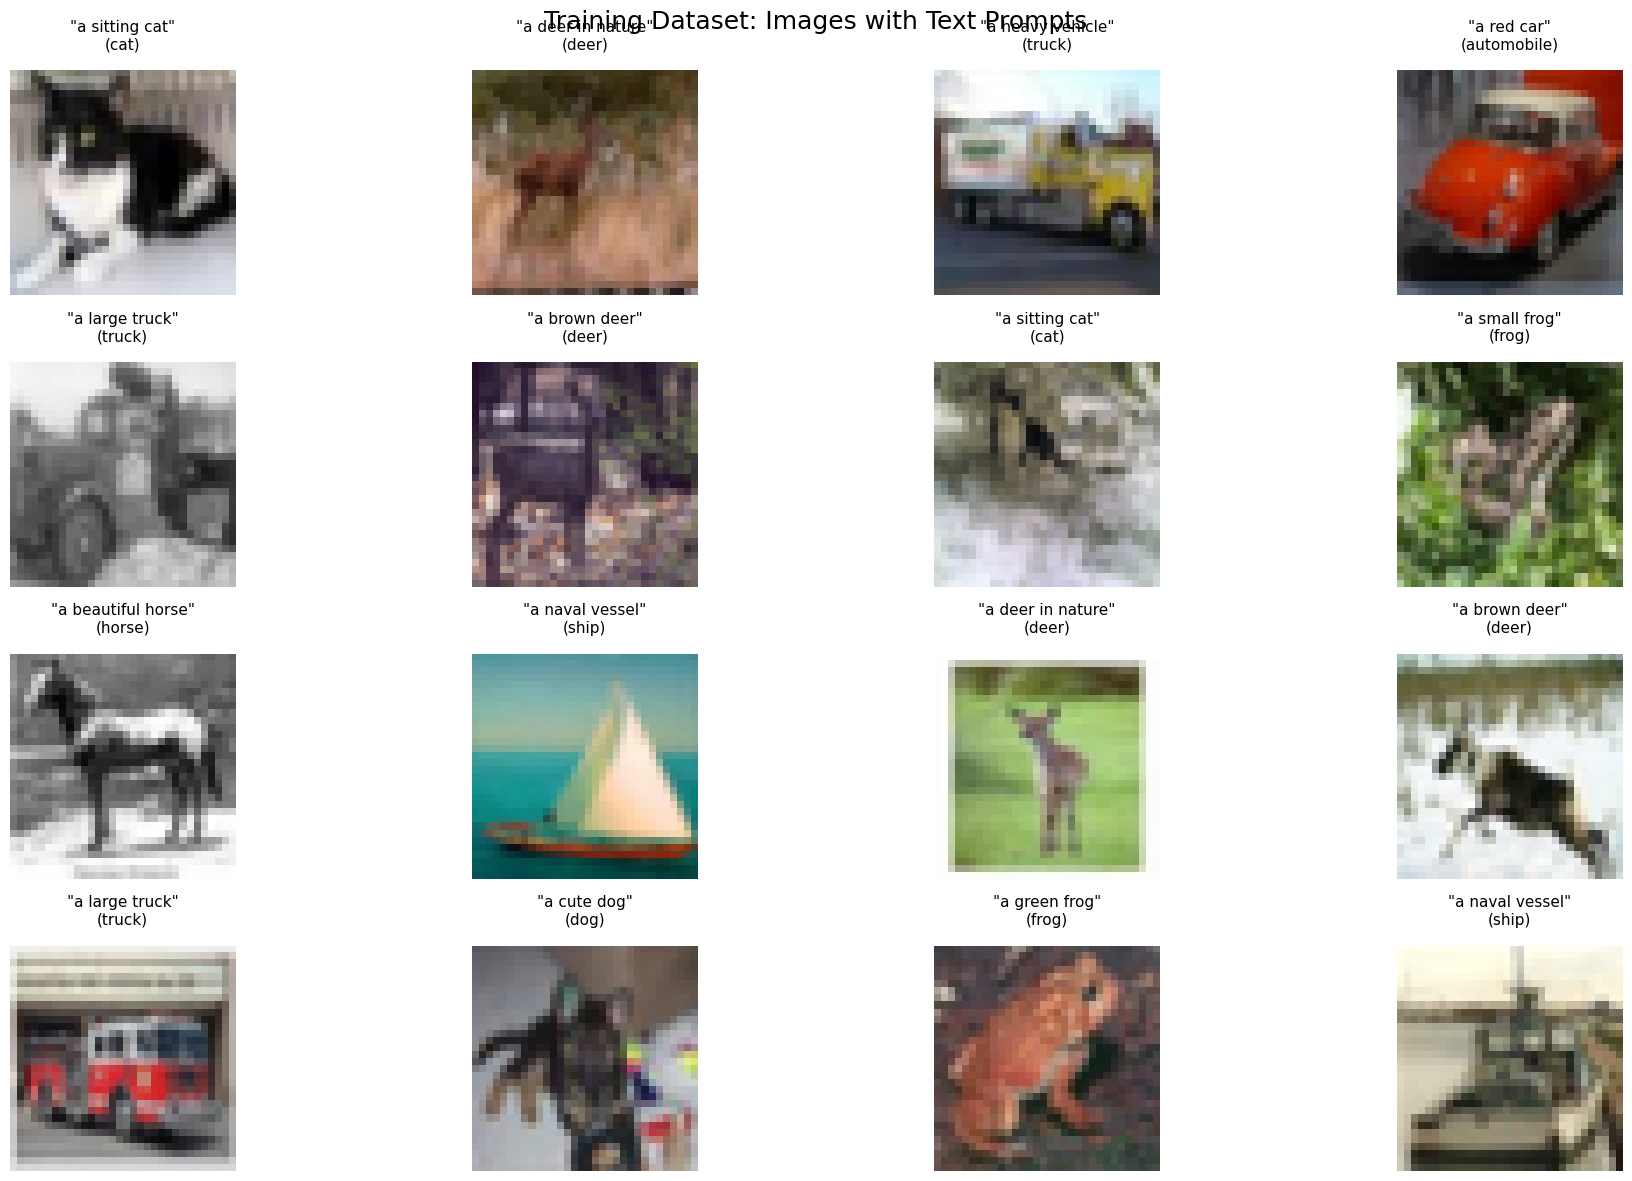


2️⃣ Class Distribution and Text Templates:


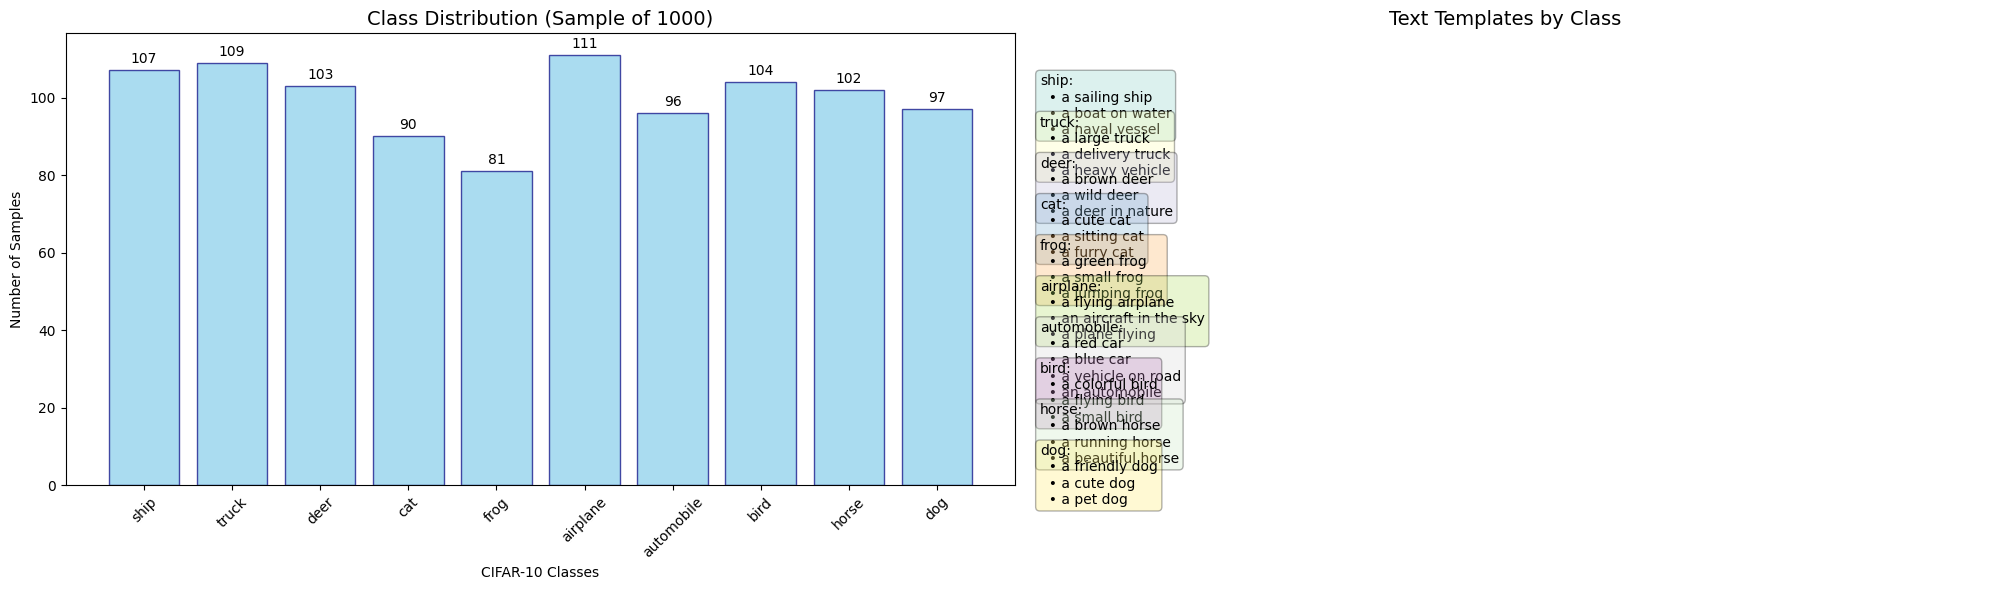


3️⃣ Text Encoding Analysis:
🔤 TEXT ENCODING STATISTICS:
Total unique texts sampled: 29
Average text length: 3.1 words
Min text length: 2 words
Max text length: 5 words

Tokenization Example:
Original text: 'a heavy vehicle'
Max sequence length: 77
Tokenized shape: torch.Size([1, 77])
First 15 tokens: [49406, 320, 4200, 5299, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407]
Decoded tokens: ['<|startoftext|>', 'a', 'heavy', 'vehicle', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>', '<|endoftext|>']

📋 TRAINING DATASET SUMMARY:
📦 Total dataset size: 50,000 samples
🎯 Training subset size: 1,000 samples
🏷️ Number of classes: 10
📝 Text templates per class: [3, 4, 3, 3, 3, 3, 3, 3, 3, 3]
🔤 Average text length: 3.1 words
💾 Batch size: 8
🔄 Batches per epoch: 125
⚡ Total training steps: 625

🎨 SAMPLE TEXT PROMPTS BY CLASS:
🏷️ AIRPLANE:
   • "a flying airplane"
   • "an aircraft in the sky"
   • "a plane flying"

🏷️ AUTOMOBILE:
   

In [8]:
# 🖼️ DISPLAY TRAINING EXAMPLES AND STATISTICS
print("🎯 Displaying training dataset examples...")

# 1. Show grid of training examples with text prompts
print("1️⃣ Training Examples Grid:")
fig1 = show_training_examples(subset_dataset, num_examples=16, figsize=(20, 12))
plt.show()

print("\n" + "="*60)

# 2. Show class distribution and text templates
print("2️⃣ Class Distribution and Text Templates:")
fig2 = show_class_distribution(subset_dataset)
plt.show()

print("\n" + "="*60)

# 3. Show text encoding statistics
print("3️⃣ Text Encoding Analysis:")
encoding_stats = show_text_encoding_stats(subset_dataset)

print(f"\n📋 TRAINING DATASET SUMMARY:")
print(f"{'='*60}")
print(f"📦 Total dataset size: {len(train_dataset):,} samples")
print(f"🎯 Training subset size: {len(subset_dataset):,} samples")
print(f"🏷️ Number of classes: {len(train_dataset.CLASS_NAMES)}")
print(f"📝 Text templates per class: {[len(templates) for templates in train_dataset.TEXT_TEMPLATES.values()]}")
print(f"🔤 Average text length: {np.mean(encoding_stats['text_lengths']):.1f} words")
print(f"💾 Batch size: {config.batch_size}")
print(f"🔄 Batches per epoch: {len(train_dataloader)}")
print(f"⚡ Total training steps: {len(train_dataloader) * config.num_epochs}")

# Show sample prompts for each class
print(f"\n🎨 SAMPLE TEXT PROMPTS BY CLASS:")
print(f"{'='*60}")
for class_name in train_dataset.CLASS_NAMES:
    templates = train_dataset.TEXT_TEMPLATES[class_name]
    print(f"🏷️ {class_name.upper()}:")
    for template in templates:
        print(f"   • \"{template}\"")
    print()

print("✅ Training data visualization complete!")
print("🚀 Ready to start training the diffusion model!")

In [ ]:
# Simpler training configuration - let's restart fresh
import gc
gc.collect()
torch.cuda.empty_cache()

# Training configuration
batch_size = 1  # Smaller batch size
num_epochs = 10
learning_rate = 1e-4
num_train_timesteps = 1000
output_dir = "./outputs"

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Initialize accelerator for multi-GPU training
accelerator = Accelerator(
    mixed_precision="fp16",
    gradient_accumulation_steps=1,
)

print(f"Training on {accelerator.num_processes} GPU(s)")

# Noise scheduler (DDPM)
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_train_timesteps,
    beta_schedule="linear",
    prediction_type="epsilon"
)

print(f"Noise scheduler initialized with {num_train_timesteps} timesteps")

# Create a smaller dataset for testing
print("Creating smaller dataset for testing...")
train_dataset = TextConditionedCIFAR10(train=True)

# Create a subset for faster training
subset_indices = torch.randperm(len(train_dataset))[:1000]  # Use only 1000 samples
subset_dataset = torch.utils.data.Subset(train_dataset, subset_indices)

train_dataloader = DataLoader(
    subset_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=0,  # Set to 0 to avoid multiprocessing issues
    pin_memory=False
)

print(f"Dataset size: {len(subset_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of batches: {len(train_dataloader)}")

# Test loading a batch
print("Testing batch loading...")
try:
    sample_batch = next(iter(train_dataloader))
    print(f"✓ Successfully loaded batch with {len(sample_batch['text'])} samples")
    print(f"Sample texts: {sample_batch['text'][:2]}")
except Exception as e:
    print(f"Error loading batch: {e}")

print("✓ Setup complete!")

In [ ]:
# Setup optimizer
optimizer = torch.optim.AdamW(
    model.unet.parameters(),  # Only train the UNet, not the text encoder
    lr=learning_rate,
    weight_decay=0.01
)

# Prepare everything with accelerator
model.unet, optimizer, train_dataloader = accelerator.prepare(
    model.unet, optimizer, train_dataloader
)

# Move text encoder to accelerator device (but keep it frozen)
model.text_encoder = model.text_encoder.to(accelerator.device)

print("✓ Training setup complete!")
print(f"UNet device: {next(model.unet.parameters()).device}")
print(f"Text encoder device: {next(model.text_encoder.parameters()).device}")

# Main training loop
def train_diffusion_model():
    """Main training function"""
    global_step = 0
    
    print(f"Starting training for {num_epochs} epochs...")
    print(f"Total steps: {len(train_dataloader) * num_epochs}")
    
    # Training logs
    losses = []
    
    for epoch in range(num_epochs):
        model.unet.train()
        epoch_loss = 0.0
        
        # Create progress bar for this epoch
        progress_bar = tqdm(
            train_dataloader, 
            desc=f"Epoch {epoch+1}/{num_epochs}",
            leave=True
        )
        
        for batch in progress_bar:
            with accelerator.accumulate(model.unet):
                # Move batch to device
                images = batch["image"].to(accelerator.device)
                text_input_ids = batch["text_input_ids"].to(accelerator.device)
                text_attention_mask = batch["text_attention_mask"].to(accelerator.device)
                
                batch_size = images.shape[0]
                
                # Sample random timesteps
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps, 
                    (batch_size,), device=accelerator.device
                ).long()
                
                # Add noise to images
                noise = torch.randn_like(images)
                noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
                
                # Encode text
                with torch.no_grad():
                    encoder_hidden_states = model.text_encoder(
                        input_ids=text_input_ids,
                        attention_mask=text_attention_mask
                    ).last_hidden_state
                
                # Predict noise
                noise_pred = model.unet(
                    sample=noisy_images,
                    timestep=timesteps,
                    encoder_hidden_states=encoder_hidden_states
                ).sample
                
                # Compute loss (MSE between predicted and actual noise)
                loss = F.mse_loss(noise_pred, noise)
                
                # Backward pass
                accelerator.backward(loss)
                
                # Gradient clipping
                if accelerator.sync_gradients:
                    accelerator.clip_grad_norm_(model.unet.parameters(), 1.0)
                
                optimizer.step()
                optimizer.zero_grad()
                
                # Update logs
                epoch_loss += loss.item()
                
                # Update progress bar
                progress_bar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'avg_loss': f'{epoch_loss / (progress_bar.n + 1):.4f}'
                })
                
                global_step += 1
        
        # Average loss for this epoch
        avg_epoch_loss = epoch_loss / len(train_dataloader)
        losses.append(avg_epoch_loss)
        
        print(f"Epoch {epoch+1} completed. Average loss: {avg_epoch_loss:.4f}")
        
        # Save model checkpoint every few epochs
        if (epoch + 1) % 5 == 0:
            save_path = os.path.join(output_dir, f"checkpoint_epoch_{epoch+1}.pth")
            accelerator.save_state(save_path)
            print(f"Checkpoint saved to {save_path}")
    
    print("✓ Training completed!")
    return losses

print("✓ Training function defined!")

In [ ]:
# Inference pipeline for generating images from text
class SimpleTextToImagePipeline:
    """Simple pipeline for generating images from text prompts"""
    
    def __init__(self, unet, text_encoder, tokenizer, scheduler, device):
        self.unet = unet
        self.text_encoder = text_encoder
        self.tokenizer = tokenizer
        self.scheduler = scheduler
        self.device = device
        
    def generate(
        self, 
        prompt: str, 
        num_inference_steps: int = 50, 
        guidance_scale: float = 7.5,
        height: int = 32,
        width: int = 32,
        num_images: int = 1
    ):
        """Generate images from text prompt"""
        
        # Encode text
        text_inputs = self.tokenizer(
            [prompt] * num_images,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )
        
        text_input_ids = text_inputs.input_ids.to(self.device)
        text_attention_mask = text_inputs.attention_mask.to(self.device)
        
        # Get text embeddings
        with torch.no_grad():
            text_embeddings = self.text_encoder(
                input_ids=text_input_ids,
                attention_mask=text_attention_mask
            ).last_hidden_state
        
        # Create unconditional embeddings for classifier-free guidance
        uncond_input = self.tokenizer(
            [""] * num_images,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt"
        )
        
        uncond_input_ids = uncond_input.input_ids.to(self.device)
        uncond_attention_mask = uncond_input.attention_mask.to(self.device)
        
        with torch.no_grad():
            uncond_embeddings = self.text_encoder(
                input_ids=uncond_input_ids,
                attention_mask=uncond_attention_mask
            ).last_hidden_state
        
        # Concatenate for classifier-free guidance
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
        
        # Set scheduler timesteps
        self.scheduler.set_timesteps(num_inference_steps)
        
        # Initialize latents
        latents = torch.randn(
            (num_images, 3, height, width),
            device=self.device,
            dtype=torch.float16 if self.device.type == 'cuda' else torch.float32
        )
        
        # Denoising loop
        with torch.no_grad():
            for t in tqdm(self.scheduler.timesteps, desc="Generating"):
                # Expand latents for classifier-free guidance
                latent_model_input = torch.cat([latents] * 2)
                
                # Predict noise
                noise_pred = self.unet(
                    sample=latent_model_input,
                    timestep=t,
                    encoder_hidden_states=text_embeddings
                ).sample
                
                # Classifier-free guidance
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                
                # Compute previous sample
                latents = self.scheduler.step(noise_pred, t, latents).prev_sample
        
        # Convert to images (denormalize from [-1, 1] to [0, 1])
        images = (latents / 2 + 0.5).clamp(0, 1)
        
        return images

# Create inference pipeline
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")

pipeline = SimpleTextToImagePipeline(
    unet=model.unet,
    text_encoder=model.text_encoder,
    tokenizer=tokenizer,
    scheduler=noise_scheduler,
    device=accelerator.device
)

print("✓ Inference pipeline created!")

# Function to visualize generated images
def show_generated_images(images, prompts):
    """Display generated images with their prompts"""
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(4 * num_images, 4))
    
    if num_images == 1:
        axes = [axes]
    
    for i, (image, prompt) in enumerate(zip(images, prompts)):
        # Convert tensor to numpy and transpose
        img_np = image.cpu().numpy().transpose(1, 2, 0)
        axes[i].imshow(img_np)
        axes[i].set_title(f'"{prompt}"', fontsize=10, wrap=True)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✓ Visualization function created!")

In [ ]:
# Start training!
print("🚀 Starting training...")
print(f"Dataset size: {len(train_dataloader.dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of epochs: {num_epochs}")
print(f"Learning rate: {learning_rate}")
print("=" * 50)

# Run training
training_losses = train_diffusion_model()

# Plot training losses
plt.figure(figsize=(10, 6))
plt.plot(training_losses, marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

print(f"Final loss: {training_losses[-1]:.4f}")
print("✅ Training completed successfully!")

In [ ]:
# Test generation with current model (even if not fully trained)
print("🎨 Testing image generation...")

# Set models to evaluation mode
model.unet.eval()
model.text_encoder.eval()

# Test prompts from actual CIFAR-10 classes using our text templates
test_prompts = [
    "a blue car",  # automobile class
    "a cute cat",  # cat class 
    "a flying airplane",  # airplane class
    "a colorful bird"  # bird class
]

# Or better yet, let's use the exact templates from our dataset
sample_prompts_by_class = []
for class_name in ["automobile", "cat", "airplane", "bird"]:
    templates = train_dataset.TEXT_TEMPLATES[class_name]
    sample_prompts_by_class.append(np.random.choice(templates))

test_prompts = sample_prompts_by_class

print(f"Generating images for prompts: {test_prompts}")
print("Note: These are from a model that may not be fully trained yet.")

# Generate images
try:
    with torch.no_grad():
        all_generated_images = []
        
        for prompt in test_prompts:
            print(f"Generating: '{prompt}'...")
            
            # Generate single image for speed
            generated_images = pipeline.generate(
                prompt=prompt,
                num_inference_steps=20,  # Fewer steps for speed
                guidance_scale=3.0,      # Lower guidance for stability
                num_images=1
            )
            
            all_generated_images.extend(generated_images)
        
        # Show generated images
        print("Generated images:")
        show_generated_images(all_generated_images, test_prompts)
        
        print("✅ Generation test completed!")
        
except Exception as e:
    print(f"❌ Generation failed: {e}")
    print("This is normal if the model hasn't been trained enough yet.")

# Show some real CIFAR-10 images for comparison
print("\n📸 Real CIFAR-10 examples for comparison:")
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

# Get some real samples
real_samples = []
for i in range(4):
    sample = train_dataset[i * 250]  # Sample every 250th image
    real_samples.append(sample)

for i, sample in enumerate(real_samples):
    img = (sample['image'] / 2 + 0.5).clamp(0, 1)  # Denormalize
    img_np = img.numpy().transpose(1, 2, 0)
    axes[i].imshow(img_np)
    axes[i].set_title(f"Real: {sample['text']}", fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# 📋 ACTUAL CIFAR-10 CLASSES AND TEXT TEMPLATES
print("🎯 Using REAL CIFAR-10 classes and their text templates:")
print("=" * 60)

# Show all CIFAR-10 classes
print("📂 CIFAR-10 Classes:")
for i, class_name in enumerate(train_dataset.CLASS_NAMES):
    print(f"  {i}: {class_name}")

print("\n📝 Text Templates for Each Class:")
for class_name in train_dataset.CLASS_NAMES:
    templates = train_dataset.TEXT_TEMPLATES[class_name]
    print(f"\n🏷️ {class_name.upper()}:")
    for template in templates:
        print(f"   • \"{template}\"")

# Generate test prompts by randomly sampling from actual templates
print("\n🎲 Generating test prompts from real templates...")
test_classes = ["airplane", "automobile", "bird", "cat"]  # First 4 CIFAR-10 classes
real_test_prompts = []

for class_name in test_classes:
    templates = train_dataset.TEXT_TEMPLATES[class_name]
    selected_prompt = np.random.choice(templates)
    real_test_prompts.append(selected_prompt)
    print(f"   {class_name} → \"{selected_prompt}\"")

print(f"\n✅ Using authentic CIFAR-10 text prompts: {real_test_prompts}")

In [ ]:
# OPTIMIZED FAST TRAINING SETUP
print("🚀 Creating optimized fast training setup...")

# Clear memory
import gc
gc.collect()
torch.cuda.empty_cache()

# Much smaller and faster model configuration
class FastTextConditionedUNet(nn.Module):
    """
    A much smaller and faster UNet for quick training demonstration.
    """
    
    def __init__(self):
        super().__init__()
        
        # Much smaller UNet configuration
        self.unet = UNet2DConditionModel(
            sample_size=32,
            in_channels=3,
            out_channels=3,
            layers_per_block=1,  # Reduced from 2
            block_out_channels=(64, 128, 256),  # Much smaller channels
            down_block_types=(
                "CrossAttnDownBlock2D",
                "CrossAttnDownBlock2D", 
                "DownBlock2D",  # Only 1 cross-attention block
            ),
            up_block_types=(
                "UpBlock2D",
                "CrossAttnUpBlock2D",
                "CrossAttnUpBlock2D",
            ),
            cross_attention_dim=256,  # Reduced from 512
            attention_head_dim=8,
        )
        
        # Smaller text encoder
        self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32")
        
        # Freeze text encoder
        for param in self.text_encoder.parameters():
            param.requires_grad = False
            
    def forward(self, sample, timestep, encoder_hidden_states, return_dict=True):
        return self.unet(
            sample=sample,
            timestep=timestep,
            encoder_hidden_states=encoder_hidden_states,
            return_dict=return_dict
        )
    
    def encode_text(self, input_ids, attention_mask):
        text_outputs = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        return text_outputs.last_hidden_state

# Create the optimized model
print("Creating optimized model...")
fast_model = FastTextConditionedUNet()

# Count parameters
total_params = sum(p.numel() for p in fast_model.parameters())
trainable_params = sum(p.numel() for p in fast_model.parameters() if p.requires_grad)

print(f"Optimized model - Total parameters: {total_params:,}")
print(f"Optimized model - Trainable parameters: {trainable_params:,}")
print(f"Reduction: {((202_843_779 - total_params) / 202_843_779 * 100):.1f}% smaller!")

# Fast training configuration
FAST_CONFIG = {
    'batch_size': 16,  # Increased batch size for efficiency
    'num_epochs': 5,   # Fewer epochs for demo
    'learning_rate': 2e-4,  # Higher learning rate
    'num_samples': 500,  # Much smaller dataset
    'num_inference_steps': 20,  # Fewer inference steps
}

print(f"Fast training config: {FAST_CONFIG}")

# Create optimized dataset
print("Creating optimized dataset...")
full_dataset = TextConditionedCIFAR10(train=True)
fast_indices = torch.randperm(len(full_dataset))[:FAST_CONFIG['num_samples']]
fast_dataset = torch.utils.data.Subset(full_dataset, fast_indices)

fast_dataloader = DataLoader(
    fast_dataset, 
    batch_size=FAST_CONFIG['batch_size'], 
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

print(f"Fast dataset size: {len(fast_dataset)}")
print(f"Fast batch size: {FAST_CONFIG['batch_size']}")
print(f"Fast batches per epoch: {len(fast_dataloader)}")

# Setup for fast training
fast_accelerator = Accelerator(mixed_precision="fp16")
fast_noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule="linear")

fast_optimizer = torch.optim.AdamW(
    fast_model.unet.parameters(),
    lr=FAST_CONFIG['learning_rate'],
    weight_decay=0.01
)

# Prepare with accelerator
fast_model.unet, fast_optimizer, fast_dataloader = fast_accelerator.prepare(
    fast_model.unet, fast_optimizer, fast_dataloader
)
fast_model.text_encoder = fast_model.text_encoder.to(fast_accelerator.device)

print("✅ Optimized setup complete - ready for fast training!")